In [1]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 33M Feb 13 11:48 data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 75M Feb 13 11:35 data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 51M Feb 13 11:45 data/Mir.csv.bz2


In [43]:
name_dataset = 'Ekonomika'

### load data

In [44]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(67453, 6)
CPU times: user 25.5 s, sys: 3.93 s, total: 29.5 s
Wall time: 24.4 s


In [45]:
df.head()

,date,topic,text,predict,text_new,lemmatized_text
0,2008-02-11 08:04:00,"""Экономика""",- Рост ВВП России в 2008 году может составить...,Экономика,рост ввп россии в году может составить заяви...,"['рост', 'ввп', 'россия', 'составить', 'журнал..."
1,2008-02-11 08:43:00,"""Экономика""",- Цены на нефть выросли в понедельник после з...,Экономика,цены на нефть выросли в понедельник после заяв...,"['цена', 'нефть', 'вырасти', 'заявление', 'вен..."
2,2008-02-11 09:34:00,"""Экономика""",- Microsoft Corp. после получения официальног...,Экономика,microsoft corp после получения официального от...,"['microsoft', 'corp', 'получение', 'официальны..."
3,2008-02-11 17:29:00,"""Экономика""","- Официальный представитель \""Газпрома\"" (РТС...",Экономика,официальный представитель \газпрома\ ртс gazp ...,"['официальный', 'газпром', 'ртс', 'gazp', 'сер..."
4,2008-02-11 17:35:00,"""Экономика""",- Россия в понедельник официально вступила в ...,Экономика,россия в понедельник официально вступила в ряд...,"['россия', 'официально', 'вступить', 'ряд', 'с..."


* parse data

In [46]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head()

,date,topic,text,predict,text_new,lemmatized_text,year,month
0,2008-02-11 08:04:00,"""Экономика""",- Рост ВВП России в 2008 году может составить...,Экономика,рост ввп россии в году может составить заяви...,"['рост', 'ввп', 'россия', 'составить', 'журнал...",2008,2
1,2008-02-11 08:43:00,"""Экономика""",- Цены на нефть выросли в понедельник после з...,Экономика,цены на нефть выросли в понедельник после заяв...,"['цена', 'нефть', 'вырасти', 'заявление', 'вен...",2008,2
2,2008-02-11 09:34:00,"""Экономика""",- Microsoft Corp. после получения официальног...,Экономика,microsoft corp после получения официального от...,"['microsoft', 'corp', 'получение', 'официальны...",2008,2
3,2008-02-11 17:29:00,"""Экономика""","- Официальный представитель \""Газпрома\"" (РТС...",Экономика,официальный представитель \газпрома\ ртс gazp ...,"['официальный', 'газпром', 'ртс', 'gazp', 'сер...",2008,2
4,2008-02-11 17:35:00,"""Экономика""",- Россия в понедельник официально вступила в ...,Экономика,россия в понедельник официально вступила в ряд...,"['россия', 'официально', 'вступить', 'ряд', 'с...",2008,2


In [47]:
df.year.value_counts()

2015    9144
2014    8654
2009    7535
2013    7130
2018    6810
2016    6361
2008    5931
2010    4902
2017    4831
2011    3094
2012    2788
2019     273
Name: year, dtype: int64

In [48]:
df.month.value_counts()

10    6509
9     6442
12    6364
3     5916
6     5732
4     5674
11    5658
7     5487
8     5158
2     5085
1     4946
5     4482
Name: month, dtype: int64

In [49]:
df.lemmatized_text = df.lemmatized_text.apply(lambda x: literal_eval(x))

### preprocess if text with lemma

In [50]:
df['text_join'] = df.text.apply(lambda x: ' '.join(x))
df.head()

,date,topic,text,predict,text_new,lemmatized_text,year,month,text_join
0,2008-02-11 08:04:00,"""Экономика""",- Рост ВВП России в 2008 году может составить...,Экономика,рост ввп россии в году может составить заяви...,"[рост, ввп, россия, составить, журналист, токи...",2008,2,- Р о с т В В П Р о с с и и в 2 0 ...
1,2008-02-11 08:43:00,"""Экономика""",- Цены на нефть выросли в понедельник после з...,Экономика,цены на нефть выросли в понедельник после заяв...,"[цена, нефть, вырасти, заявление, венесуэла, у...",2008,2,- Ц е н ы н а н е ф т ь в ы р о с л ...
2,2008-02-11 09:34:00,"""Экономика""",- Microsoft Corp. после получения официальног...,Экономика,microsoft corp после получения официального от...,"[microsoft, corp, получение, официальный, отка...",2008,2,- M i c r o s o f t C o r p . п о с л ...
3,2008-02-11 17:29:00,"""Экономика""","- Официальный представитель \""Газпрома\"" (РТС...",Экономика,официальный представитель \газпрома\ ртс gazp ...,"[официальный, газпром, ртс, gazp, сергей_купри...",2008,2,- О ф и ц и а л ь н ы й п р е д с т а в ...
4,2008-02-11 17:35:00,"""Экономика""",- Россия в понедельник официально вступила в ...,Экономика,россия в понедельник официально вступила в ряд...,"[россия, официально, вступить, ряд, странучаст...",2008,2,- Р о с с и я в п о н е д е л ь н и к ...


* add docID

In [51]:
df['docID'] = list(range(df.shape[0]))

In [52]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[рост, ввп, россия, составить, журналист, токи..."
1,1,2008,2,"[цена, нефть, вырасти, заявление, венесуэла, у..."


In [53]:
print(df.shape)
df.isnull().sum()

(67453, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [54]:
df.year.min(),df.year.max()

(2008, 2019)

### preprocess if text full

* get dates

In [55]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

<unknown>:2: DeprecationWarning: invalid escape sequence \d


KeyError: 'url'

* clean text

In [56]:
import preprocessing_tools as pr

In [57]:
%%time
df.text = df.text.apply(pr.clean_text)

AttributeError: 'DataFrame' object has no attribute 'text'

In [58]:
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[рост, ввп, россия, составить, журналист, токи..."
1,1,2008,2,"[цена, нефть, вырасти, заявление, венесуэла, у..."


* cleanedNames

In [59]:
from cleanedNames import KeyProc
cn = KeyProc()

In [60]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

AttributeError: 'DataFrame' object has no attribute 'text'

* lemmatization

In [61]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

AttributeError: 'DataFrame' object has no attribute 'text'

* add docID

In [62]:
df['docID'] = list(range(df.shape[0]))

In [63]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[рост, ввп, россия, составить, журналист, токи..."
1,1,2008,2,"[цена, нефть, вырасти, заявление, венесуэла, у..."


In [64]:
print(df.shape)
df.isnull().sum()

(67453, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [65]:
df.year.min()

2008

## model

* prepare

In [66]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 897 ms, sys: 231 ms, total: 1.13 s
Wall time: 946 ms


In [67]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [68]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/Ekonomika", num_batches=72)
CPU times: user 31.8 s, sys: 1.02 s, total: 32.8 s
Wall time: 4.43 s


In [69]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [70]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=cea75630-3ddb-4714-b6dd-69368fa2b20a, num_entries=24662)

In [71]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 6
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

In [ ]:
#model_list

In [ ]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [ ]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

In [ ]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

In [ ]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [ ]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

In [ ]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

In [ ]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [ ]:
perplexity

### select the best model

In [ ]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

In [ ]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

---

In [75]:
select_topics = 20

In [76]:
num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')


	SparsityThetaScore: 0.7098249197006226
	SparsityPhiScore: 0.8655847311019897
	PerplexityScore: 2135.237060546875


In [77]:
best_model = model.clone()
best_model.num_topics

20

---

### print top words for each topics

In [78]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['валюта' 'валютный' 'рейтинг' 'облигация' 'минфин' 'доходность'
 'иностранный' 'операция' 'национальный' 'центробанк']
topic_1: ['акционер' 'втб' 'русало' 'пакет' 'иск' 'председатель' 'сбербанк' 'пост'
 'оао' 'владеть']
topic_2: ['инфляция' 'ввп' 'темп' 'потребительский' 'доход' 'расход' 'выражение'
 'дефицит' 'минэкономразвития' 'спрос']
topic_3: ['требование' 'операция' 'деятельность' 'информация' 'лицензия'
 'кредитный' 'банковский' 'лицо' 'вклад' 'нарушение']
topic_4: ['кредит' 'банковский' 'кредитный' 'триллион' 'сбербанк' 'долг' 'резерв'
 'кредитование' 'задолженность' 'вэб']
topic_5: ['пенсионный' 'пенсия' 'выплата' 'зарплата' 'возраст' 'гражданин'
 'работник' 'социальный' 'страховой' 'труд']
topic_6: ['санкция' 'добыча' 'опека' 'иран' 'бс' 'саудовский' 'аравия' 'нефтяной'
 'соглашение' 'сутки']
topic_7: ['очень' 'деньга' 'нужно' 'хороший' 'подчеркнуть' 'поэтому' 'сделать'
 'бизнес' 'важный' 'делать']
topic_8: ['авиакомпания' 'оператор' 'аэрофлот' 'аэропорт' 'самолёт' 

### get topics-docs matrix

shape theta: (20, 71288)


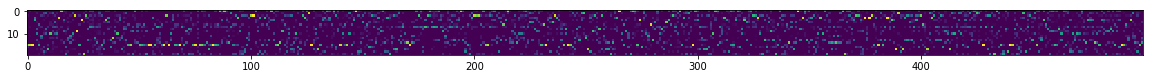

In [79]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [80]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
46000,0.000000,0.008096,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.960834,0.000000,0.000000,0.024151,0.00692
46001,0.289113,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.078895,0.0,0.0,0.0,0.03775,0.0,0.000000,0.043417,0.103126,0.052464,0.000000,0.395234,0.00000
46002,0.000000,0.000000,0.00000,0.044809,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.797049,0.000000,0.000000,0.100586,0.057556,0.00000
46003,0.000000,0.000000,0.00000,0.928548,0.064301,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.007151,0.00000
46004,0.162148,0.000000,0.45024,0.000000,0.000000,0.0,0.045609,0.289935,0.0,0.0,0.0,0.00000,0.0,0.013895,0.000000,0.000000,0.038172,0.000000,0.000000,0.00000


## DataViz

In [81]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,2008,2,0.075365,0.000000,0.404137,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.052178
1,1,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.416634,0.076958,0.000000,0.000000,0.421052,0.0,0.0,0.0,0.003347
2,2,2008,2,0.000000,0.060302,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.174430
3,3,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.441703,0.000000,0.000000,0.487940,0.070356,0.0,0.0,0.0,0.000000
4,4,2008,2,0.003908,0.005936,0.018436,0.0,0.123395,0.0,0.204657,...,0.057331,0.130793,0.000000,0.034934,0.059186,0.000000,0.0,0.0,0.0,0.000000


In [82]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (132, 20)


topic_0    topic_1    topic_2    topic_3    topic_4    topic_5  \
year month                                                                     
2008 2       3.287907   4.690537   6.080908   3.181068   3.555638   5.262277   
     3      13.859481  17.303555  14.120027  12.862632  14.994427  13.593679   
     4       6.052788  26.739037  19.851948  11.176023  13.931796   6.927900   
     5       4.360681  20.289297  26.907614  10.521105   5.586431   9.018892   
     6       8.365531  38.784832  28.335680  17.932655  12.079234   8.525244   

             topic_6    topic_7    topic_8   topic_9   topic_10   topic_11  \
year month                                                                   
2008 2      1.753372  10.569671   3.286643  2.606251   6.230358   7.239669   
     3      2.866247  25.383051  19.552624  6.875682  28.696926  14.364385   
     4      3.325070  20.176460  21.047289  7.687934  27.040483  19.034397   
     5      3.796125  20.250999   9.087646  4.846000  18.170540  11.650507   
     6      6.147474  32.727234   8.130958  5.552958  29.197636  21.747412   

             topic_12   topic_13   topic_14   topic_15   topic_16   topic_17  \
year month                                                                     
2008 2       4.431345   7.256612  15.241473  11.445597   2.700191   1.350780   
     3       9.597087  19.106001  37.110737  24.277878  12.381278  12.227842   
     4       9.194066  16.407066  23.260824  15.570524  10.078652  10.161418   
     5      17.735672  18.747602  24.455679  25.520605   9.748255   8.161143   
     6      18.280865  28.437252  25.397209  14.108525  11.564077  11.234771   

            topic_18   topic_19  
year month                       
2008 2      2.414825   7.414878  
     3      7.892206  18.934256  
     4      7.933931   8.402390  
     5      4.095467   5.049741  
     6      7.557011   6.893442

### straightforward matrix heatmap

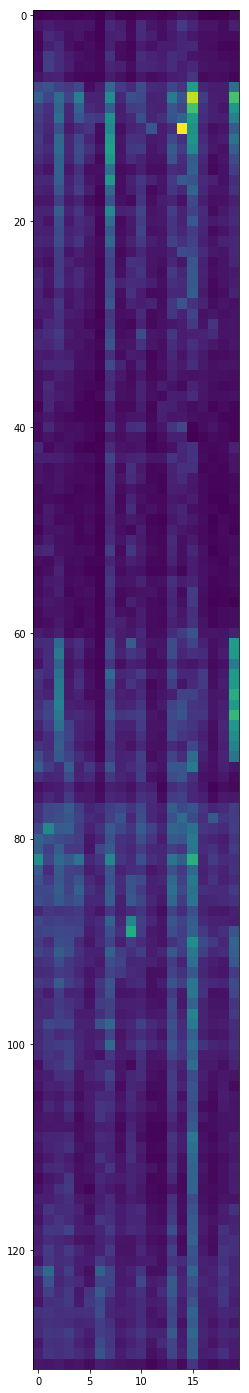

In [83]:
plt.figure(figsize=(5, 25))
plt.imshow(gb[topics])

## pygal

In [84]:
import pygal
from IPython.display import SVG, HTML

In [85]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [86]:
max(gb['topic_1'].values)

101.48074

In [87]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [88]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [89]:
import joypy # !pip install joypy

In [90]:
print(joined.shape)
joined.head()

(67453, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,2008,2,0.075365,0.000000,0.404137,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.052178
1,1,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.416634,0.076958,0.000000,0.000000,0.421052,0.0,0.0,0.0,0.003347
2,2,2008,2,0.000000,0.060302,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.174430
3,3,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.441703,0.000000,0.000000,0.487940,0.070356,0.0,0.0,0.0,0.000000
4,4,2008,2,0.003908,0.005936,0.018436,0.0,0.123395,0.0,0.204657,...,0.057331,0.130793,0.000000,0.034934,0.059186,0.000000,0.0,0.0,0.0,0.000000


In [91]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,date
0,0,2008,2,0.075365,0.000000,0.404137,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.052178,2008-02-01
1,1,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.416634,0.076958,0.000000,0.000000,0.421052,0.0,0.0,0.0,0.003347,2008-02-01
2,2,2008,2,0.000000,0.060302,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.174430,2008-02-01
3,3,2008,2,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.441703,0.000000,0.000000,0.487940,0.070356,0.0,0.0,0.0,0.000000,2008-02-01
4,4,2008,2,0.003908,0.005936,0.018436,0.0,0.123395,0.0,0.204657,...,0.130793,0.000000,0.034934,0.059186,0.000000,0.0,0.0,0.0,0.000000,2008-02-01


In [92]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd.head()

,date,topic,mentions
0,2008-02-01,topic_0,0.075365
4,2008-02-01,topic_0,0.003908
6,2008-02-01,topic_0,0.053787
10,2008-02-01,topic_0,0.153822
12,2008-02-01,topic_0,0.046989


In [93]:
dd2 = dd.groupby(['date','topic']).sum()
dd2.head()

mentions
date       topic             
2008-02-01 topic_0   3.287907
           topic_1   4.690537
           topic_10  6.230358
           topic_11  7.239669
           topic_12  4.431345

In [94]:
dd2=dd2.reset_index()
dd2.head()

,date,topic,mentions
0,2008-02-01,topic_0,3.287907
1,2008-02-01,topic_1,4.690537
2,2008-02-01,topic_10,6.230358
3,2008-02-01,topic_11,7.239669
4,2008-02-01,topic_12,4.431345


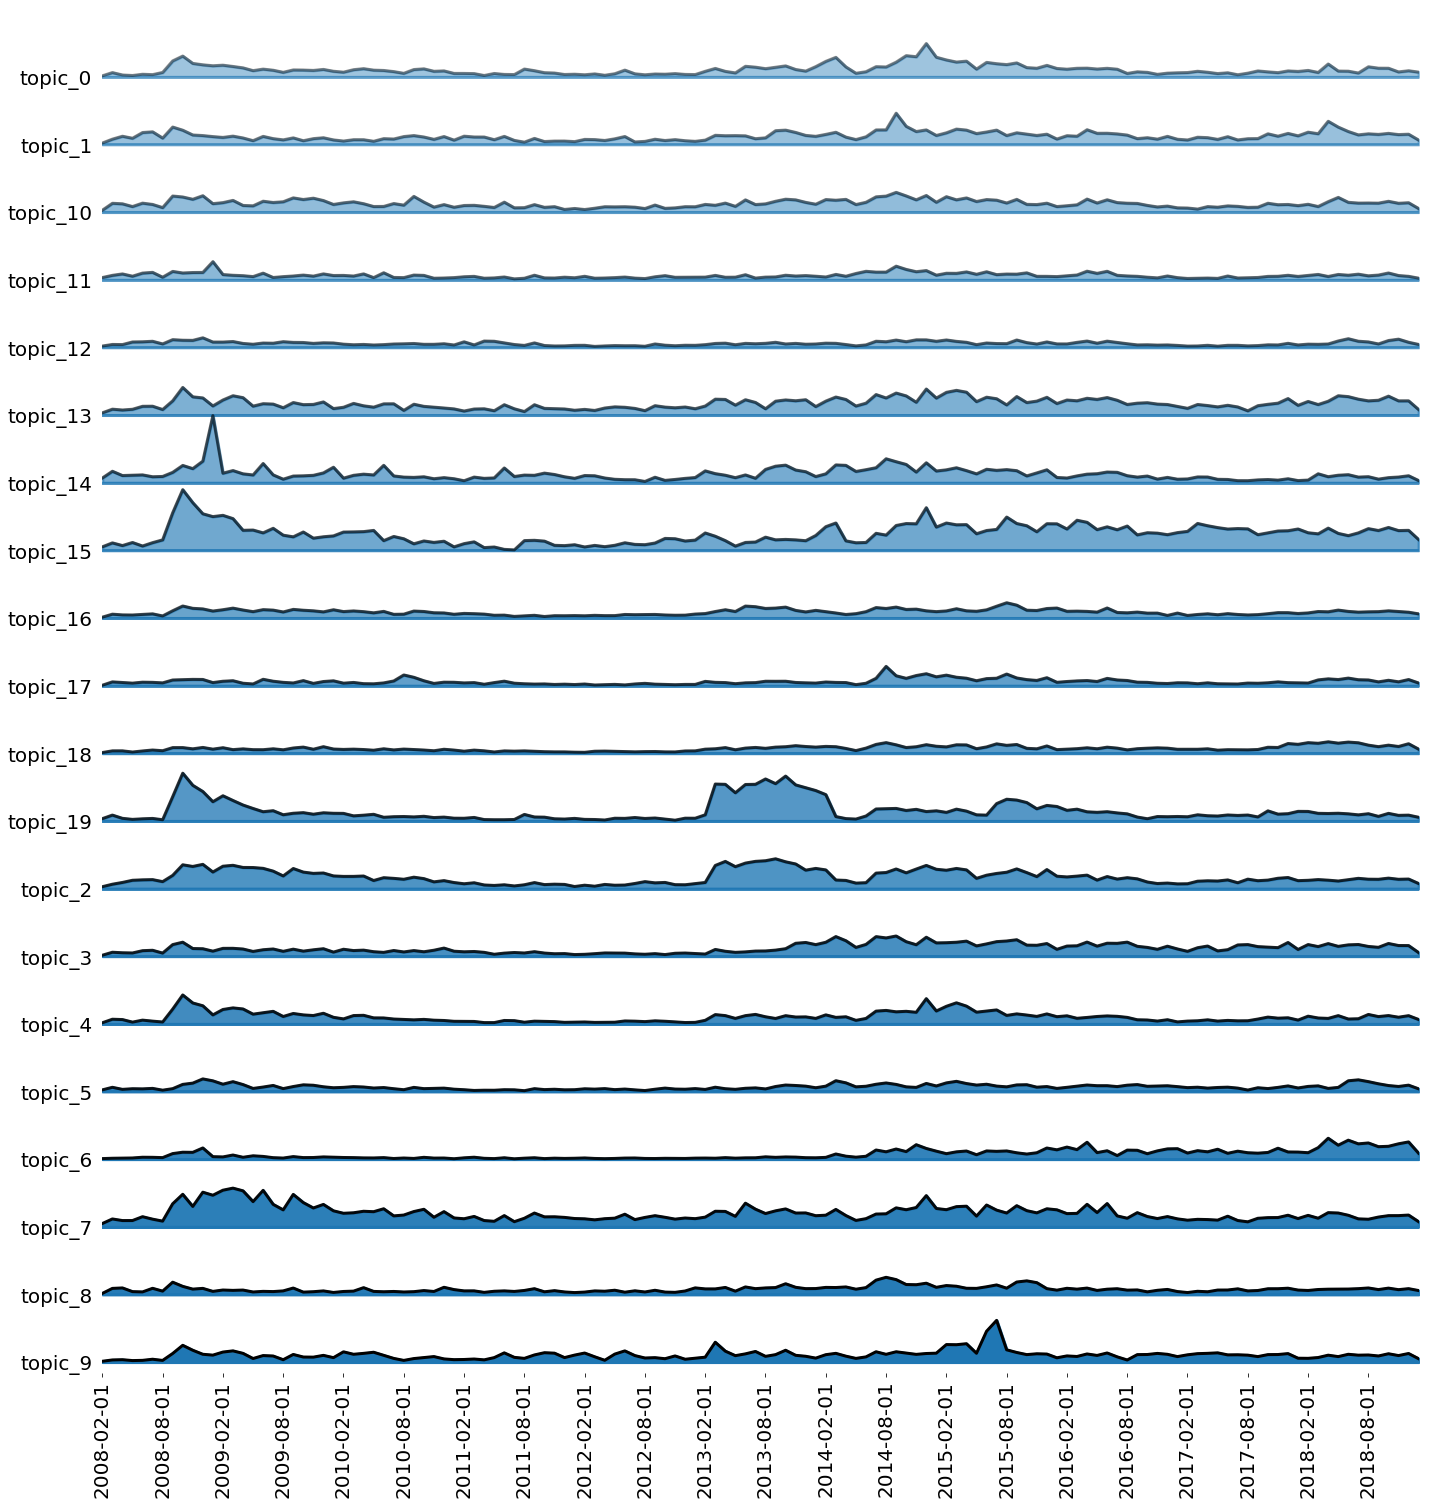

In [95]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [96]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")